# Finite Galilean Group in 1+1 dimensions


             _
         __ ( }
       '---. _`---,
       ___/ /
     /,---'\\
           //
          '==
_Art by Joan Stark_

__Table of Content__:
1. Definition of the Group Action
    1. $\mathcal{Gal}_3(1+1)$
    2. Info about Elements
    3. The Group Action
2. Representation Theory
    1. Irreps and Character Table
    2. Projection on $\mathcal{U}_{-1,0} \oplus \mathcal{U}_{0,0} \oplus \mathcal{U}_{1,0}$
    3. Projection on $\mathcal{V} \oplus \mathcal{V'}$
    4. Interpretation of the Decomposition
3. Harmonic Analysis
    1. Definition
    2. Interpretation of the Coefficients
    3. Interpretation of the Product
4. Real Representations


In [1]:
import itertools
import numpy as np
from galilean import Galilean1p1
from matplotlib import pyplot as plt

plt.style.use("dark_background")

# constants
w = np.exp(2j*np.pi/3)
m = 1/w
span = [-1,0,1]

## 1. Definition of the Group and Action

### 1.1 Definition of $\mathcal{Gal}_3(1+1)$

The 1+1 Galilean group is chiefly defined by its generators and relations.
The generators correspond to movement you can do in that spacetime, they are:
1. Space translations: D (lie generator), $g(x,0,0)$
1. Time transaltions: H (lie generator), $g(0,s,0)$
1. Boosts: B (lie generator), $g(0,0,s)$

Those generators verify:

$$
[D,H] = e \\
[B,D] = e \\
[B,H] = D^{-1}
$$

Any element can be uniquely written $D^xH^tB^v$, or in code `Galilean1p1(x,t,v)`.
The group definition is detailed in 'galilean.py' in the class `Galilean1p1`.

__Truncation of the group__: The group $\mathcal{Gal}(1+1)$ is infinite. We turn it into a finite group by imposing the additional relations:  
$$D^3 = H^3 = B^3 = e$$
We'll note the group thus obtained $\mathcal{Gal}_3(1+1)$.

### 1.2 Element Information about the Group

#### Group Structure

__Exercise__: Show that the sequence $0 \rightarrow \langle D, H\rangle \rightarrow G \rightarrow \langle B\rangle \rightarrow 0$ is exact and right-split.
Alternatively if you don't like the language of exact sequences, show that G is a semi-direct product of $\langle D, H\rangle$ and $\langle B\rangle$.


Since D and H commute, we now know that $\lt D, H \gt \sim \mathbb{Z}/3 \times \mathbb{Z}/3$, and together with the previous exercise this gives us that __G has 27 elements__.


__Exercise__: Show that $Z(G) = \langle D \rangle$ and deduce the normal series: 
$0 \lhd \langle D \rangle \lhd \langle D, H \rangle \lhd G$


__Exercise__: Prove that $G/{Z(G)} \sim \mathbb{Z}/3\times \mathbb{Z}/3$

> _Hint_: There are only 2 groups of order 9: $Z/9$ and $Z/3 \times Z/3$.

#### Conjugacy Classes

__Exercise__: Find all the __conjugacy classes__ of G.

> _Answer_: There are 11 classes:
> * 3 classes of size 1, given by representants $e, D, D^{-1}$
> * 8 classes of size 3, given by representants $H, H^{-1}, B, HB, H^{-1}B, B^{-1}, HB^{-1}, H^{-1}B^{-1}$


### 1.3 Definition of the group action on observations
Let's start by defining our observations.
They are fields, we have one (complex-valued) observation for each point (x,t) in space and time.
To make it more accessible to computations, we limit both time and space to the range [-1, 0, 1].

In [2]:
def obs_xt_basis(x : int,t : int):
    """ Basis of observation functions given by indicator.
    Params:
        x (int): Index between -1 and 1
        t (int): Index between -1 and 1
    """
    res = np.zeros((3,3), dtype=complex)
    res[1-t,x+1] = 1
    return res

def xt(x : int, t : int):
    """ Makes it easy to index into matrix when they represent an observation.
    
    If an observation is represented by a 3x3 matrix M, then the observation
    value at position x and time t is given by `M[xt(x,t)]`.
    
    This function is needed because our indexing of space and time does not
    coincide with the matrix default notation.
    
    Params:
        x (int): Index, converted to -1 and 1 range
        t (int): Index, converted to -1 and 1 range
    """
    return (1-mod3(t), mod3(x)+1)

def to_std_range(a):
    """ Projects indexes into [-1, 0, 1] range. """
    canon = a % 3
    if canon == 2:
        return -1
    else:
        return canon

# this alias is more convenient
mod3 = to_std_range

In [3]:
print("Testing obs_xt_basis...")
expected = np.zeros((3,3))
expected[1,1] = 1
np.testing.assert_almost_equal(
    obs_xt_basis(0,0),
    expected,
    err_msg="Basis f(0,0) should just have a 1 at the middle"
    )

expected = np.zeros((3,3))
expected[0,0] = 1
np.testing.assert_almost_equal(
    obs_xt_basis(-1,1),
    expected,
    err_msg="Basis f(x=-1,t=1) should just have a 1 at the top left corner"
    )
print("Ok.")

Testing obs_xt_basis...
Ok.


We also define a hermitian product between observations, which is given by multiplying coordinate wise and then summing.

In [4]:
def BF(obs_1, obs_2=None):
    """ Invariant hermitian form.
    Params:
        obs_2 (observation): If none, then we compute the norm of `obs_1`
    """
    # if we use the function to compute the norm we also
    # convert the result to a real number type for convenience
    convert_to_real = lambda x: x
    if obs_2 is None:
        obs_2=obs_1
        convert_to_real = np.real
    return convert_to_real(
        1/9*np.einsum('ij,ij->', obs_1, np.conjugate(obs_2))
    )

In [5]:
def display_obs(obs, ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.imshow(
        # we plot the amplitude of the complex numbers
        np.sqrt(np.real(obs * np.conj(obs))),
        extent=(-1.5,1.5,-1.5,1.5),
        cmap='hot', interpolation='nearest')
    ax.set_ylabel('Time ->')
    ax.set_yticks([-1,0,1])
    ax.set_xlabel('Space ->')
    ax.set_xticks([-1,0,1])
    ax.set_title("Observation plot, norm={:.2f}".format(
        BF(obs))
             )
display_obs(obs_xt_basis(0,0))

Now we compute how the observation change when the observer changes.
We account for 3 basic types of displacements between observers:
1. Change in position
1. Change in clock
1. Change in speed

In [6]:
def act_D(obs, power=1):
    """ Action of D on the space of observations.
    """
    return np.roll(obs, -power, axis=1)

def act_H(obs, power=1):
    """ Action of H on the space of observations.
    """
    power = to_std_range(power)
    return np.roll(obs, power, axis=0)

def act_B(obs, power=1):
    """ Action of B on the space of observations.
    """
    return np.array([
        np.roll(obs[0,:], -power),
        obs[1,:],
        np.roll(obs[2,:], power)
    ])

def act(x,t,a):
    """ General action of the group.
    We take advantage of the fact that any group element can be written:
    D^xH^tB^a.
    """
    return lambda obs: act_D(act_H(act_B(obs, a), t), x)

def act_gal(gal):
    """ General action of the group.
    Args:
        gal (Galilean1p1): group element
    """
    return lambda obs: act_D(act_H(act_B(obs, gal.v), gal.t), gal.x)

The action of D corresponds to moving an observer 1 step to the right (positive x direction).
The observation $D\cdot f$ represents intuitively the observation f as observed by the translated observer.  
In particular, assume that we observe f(0,0), then our observer will observe the same value at (-1,0) because he is now standing at (1,0), so (0,0) looks like behind from him.
From this kinds of reasoning we derive the following tests:

In [7]:
print("Testing basic sanity of action on observations...")
test_obs = np.random.normal(size=(3,3))
assert test_obs[xt(0,0)] == act_D(test_obs)[xt(-1,0)]
assert test_obs[xt(0,0)] == act_H(test_obs)[xt(0,-1)]
assert test_obs[xt(0,0)] == act_B(test_obs)[xt(0,0)]
assert test_obs[xt(0,1)] == act_B(test_obs)[xt(-1,1)], (
    "What B-observer sees behind him at time 1, " + 
    "is what we see where we are at same time")
print("Ok.")

Testing basic sanity of action on observations...
Ok.


In [8]:
print("This verifies that the hermitian product is invariant...")
obs_a = np.random.normal(size=(3,3)) + np.random.normal(size=(3,3))*1j
obs_b = np.random.normal(size=(3,3)) + np.random.normal(size=(3,3))*1j
for gen in [act_D, act_H, act_B]:
    np.testing.assert_almost_equal(
      BF(gen(obs_a), gen(obs_b)),
      BF(obs_a, obs_b)
)
print("Ok.")

This verifies that the hermitian product is invariant...
Ok.


In [9]:
print("Testing commutation relationships at action level...")
obs_test = np.random.normal(size=(3,3))
assert (act_B(act_H(obs_test)) ==  
        act_D(act_H(act_B(obs_test)), -1)).all()
assert (act_D(act_H(obs_test)) ==  
        act_H(act_D(obs_test))).all()
assert (act_B(act_D(obs_test)) ==  
        act_D(act_B(obs_test))).all()
print("Ok.")

Testing commutation relationships at action level...
Ok.


In [10]:
print("Testing group action axioms...")
random_obs = np.random.normal(size=(3,3))
p1 = Galilean1p1(*np.random.choice([-1,0,1], 3))
p2 = Galilean1p1(*np.random.choice([-1,0,1], 3))
np.testing.assert_allclose(
    act_gal(p1)(act_gal(p2)(random_obs)),
    act_gal(p1*p2)(random_obs)
)
print("Ok.")

Testing group action axioms...
Ok.


Our observations clearly represent functions $\mathrm{obs}: [-1,0,1]^2 \rightarrow \mathbb{C}$.
The action we have defined is given by the equation:
$$g \cdot \mathrm{obs}(x,t) = \mathrm{obs}(g^{-1} * (x,t))$$
Where $*$ is the `Galilean1p1.act_event` action on two dimensions (x,t)

In [11]:
obs_test = np.array([
    [1,2,3],
    [4,5,6],
    [7,8,9]
])
x,t = np.random.choice([-1,0,1], 2)
d = Galilean1p1(1,0,0)
h = Galilean1p1(0,1,0)
b = Galilean1p1(0,0,1)
assert act_D(obs_test)[xt(x,t)] == obs_test[xt(*d.inv().act_event(x,t))]
assert act_H(obs_test)[xt(x,t)] == obs_test[xt(*h.inv().act_event(x,t))]
assert act_B(obs_test)[xt(x,t)] == obs_test[xt(*b.inv().act_event(x,t))]

## 2. Decomposition into irreps

Here we have the basis functions to decompose the observation space into irreps.
We have the decomposition:

$$\mathcal{F} = \mathcal{U}_{-1,0} \oplus \mathcal{U}_{0,0} \oplus \mathcal{U}_{1,0} \oplus \mathcal{V} \oplus \mathcal{V'}$$

In order to find a decomposition basis, we use the __projection formula__:

$$\pi_W = {\mathrm{dim} W \over |G|} \sum_{g \in G} \overline{\chi_W(g)} \cdot g :
 \mathcal{F} \rightarrow \mathcal{F}$$

Where by g we mean $\rho(g) : \mathcal{F} \rightarrow \mathcal{F}$

This formula will give us a basis for each irrep in $\mathcal{F}$, but before that, we'll justify the decomposition.

### 2.1 Characters and Irreps

__Character table of G__:


| Conj class (size)               	| $e$ (1) 	| $D$ (1)         	| $D^{-1}$ (1)         	| H (3)        	| $H^{-1}$ (3)        	| B (3)        	| BH (3)        	| $BH^{-1}$ (3)         	| $B^{-1}$ (3)        	| $HB^{-1}$ (3)         	| $H^{-1}B^{-1}$ (3)              	|
| :----------------:	|---	|-----------	|-----------	|----------	|----------	|----------	|----------	|-----------	|----------	|-----------	|----------------	|
| $\chi_{0,0}$   	| 1 	| 1         	| 1         	| 1        	| 1        	| 1        	| 1        	| 1         	| 1        	| 1         	| 1              	|
| $\chi_{0,1}$   	| 1 	| 1         	| 1         	| 1        	| 1        	| w        	| w        	| w         	| $w^{-1}$ 	| $w^{-1}$  	| $w^{-1}$       	|
| $\chi_{0,-1}$  	| 1 	| 1         	| 1         	| 1        	| 1        	| $w^{-1}$ 	| $w^{-1}$ 	| $w^{-1}$  	| w        	| w         	| w              	|
| $\chi_{1,0}$   	| 1 	| 1         	| 1         	| w        	| $w^{-1}$ 	| 1        	| w        	| $w^{-1}$  	| 1        	| w         	| $w^{-1}$       	|
| $\chi_{1,1}$   	| 1 	| 1         	| 1         	| w        	| $w^{-1}$ 	| w        	| $w^{-1}$ 	| 1         	| $w^{-1}$ 	| 1         	| w              	|
| $\chi_{1,-1}$  	| 1 	| 1         	| 1         	| w        	| $w^{-1}$ 	| $w^{-1}$ 	| 1        	| w         	| w        	| $w^{-1}$  	| 1              	|
| $\chi_{-1,0}$  	| 1 	| 1         	| 1         	| $w^{-1}$ 	| w        	| 1        	| $w^{-1}$ 	| w         	| 1        	| $w^{-1}$  	| w              	|
| $\chi_{-1,1}$  	| 1 	| 1         	| 1         	| $w^{-1}$ 	| w        	| w        	| 1        	| $w^{-1}$  	| $w^{-1}$ 	| w         	| 1              	|
| $\chi_{-1,-1}$ 	| 1 	| 1         	| 1         	| $w^{-1}$ 	| w        	| $w^{-1}$ 	| w        	| 1         	| w        	| 1         	| $w^{-1}$       	|
| $\chi_V$       	| 3 	| 3w        	| $3w^{-1}$ 	| 0        	| 0        	| 0        	| 0        	| 0         	| 0        	| 0         	| 0              	|
| $\chi_V'$       	| 3 	| $3w^{-1}$ 	| 3w        	| 0        	| 0        	| 0        	| 0        	| 0         	| 0        	| 0         	| 0              	|



#### Derivation of the Character Table

__Exercise__: Compute the full character table of G.

__Hints__: G has 11 conjugacy classes so we know it has 11 irreducible representations.
9 of them can be obtained by computing the representations of $G/{Z(G)} \sim \mathbb{Z}/3\times \mathbb{Z}/3$ and pulling them back to G.
Using the orthogonality relationships, we can deduce that the 2 remaining irreps have both dimension 3.
Let's call them V and V', let's note $\rho: G \rightarrow \text{GL}(V)$ the representation.
D acts on V and has 3 eigenvectors. Considering the actions of V and V' on these, conclude that they must all have equal eigenvalues.
So $\rho(D) =  \lambda I_3$, we must also have $\lambda ^ 3 = 1$ so we can pick $\rho(D) = \omega I_3$.
We can now consider the 3 eigenvector of H on V and how B must act on them,
from which we can shows that all the eigenvalues of H must be distincts and that B permutes H's eigenvectors.
Accordingly, we can choose:

$$\rho(H) = 
\begin{pmatrix} 
1 & 0 & 0 \\
0 & \omega & 0 \\
0 & 0 & \omega^{-1} \end{pmatrix}$$ 

and

$$
\rho(B) = \begin{pmatrix}
0 & 1 & 0\\
0 & 0 & 1\\
1 & 0 & 0 \end{pmatrix}
$$

We can check that the above matrices verify the relations of G, which makes it a valid representation.
Computing the trace of every conjugacy class, we verify that $\langle \chi_V, \chi_V \rangle = 1$ which shows that it is irreducible.

Finally, using the orthogonality relationships, we can find the last row.

__Representation matrices__

The actual operators of the representations are given by the trace itself for the 9 unidimensional irreps.
For V, we can take the matrices given in the hints of the previous exercise.

For V' we can use the conjugate of the matrices for V!


### 2.2 Projection on $\mathcal{U}_{-1,0} \oplus \mathcal{U}_{0,0} \oplus \mathcal{U}_{1,0}$

In [12]:
# character for U as a function G -> C + projection formula
def U_char(s,b):
    """ Character function"""
    char_H, char_B = w**s, w**b
    return (lambda x,t,a: char_H**t * char_B**a)

def proj_irrep(char_func, obs, norm=False):
    """ Project to irrep given by its character.
    Params:
        norm (bool): If True, we normalize the result to BF-norm 1.
    """
    projed_obs = np.zeros((3,3), dtype=complex)
    for x in [-1,0,1]:
        for t in [-1, 0, 1]:
            for a in [-1, 0, 1]:
                projed_obs += np.conjugate(char_func(x,t,a)) * act_D(act_H(act_B(obs, a), t), x)
    if norm: 
        return projed_obs/np.sqrt(BF(projed_obs))
    else:
        return 1/27*projed_obs
    

def u(t,a=0):
    """ Basis of observations for the 1D irreps of F.
    """
    assert a==0, "a!=0 not implemented"
    if t == 0:
        return np.array([
            [1,1,1],
            [1,1,1],
            [1,1,1]
        ])
    elif t == -1:
        return np.array([
            [m,m,m],
            [1,1,1],
            [w,w,w],
        ])
    elif t == 1:
        return np.array([
            [w,w,w],
            [1,1,1],
            [m,m,m],
        ])

In [13]:
print("Testing projections on U(i,0) factors...")
for s in [-1, 0, 1]:
    np.testing.assert_allclose(
        proj_irrep(U_char(s,0), obs_xt_basis(s,0), True), 
        u(s),
        atol=1e-7
    )
print("OK.")

Testing projections on U(i,0) factors...
OK.


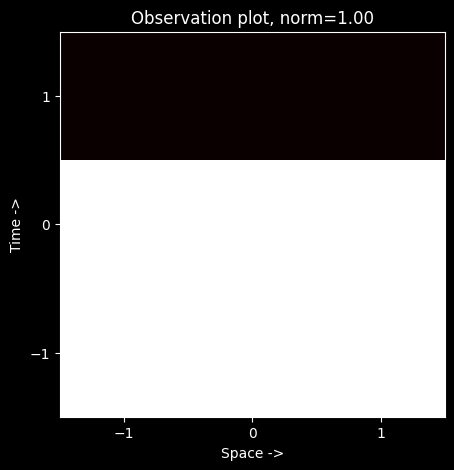

In [14]:
display_obs(u(1))

In [15]:
print("Testing U(s,0) basis vectors behave as expected under G-action...")
for s in [-1,0,1]:
    np.testing.assert_almost_equal(act_D(u(s)), U_char(s, 0)(1, 0, 0)* u(s))
    np.testing.assert_almost_equal(act_H(u(s)), U_char(s, 0)(0, 1, 0)* u(s)) 
    np.testing.assert_almost_equal(act_B(u(s)), U_char(s, 0)(0, 0, 1)* u(s))
print("Ok.")

Testing U(s,0) basis vectors behave as expected under G-action...
Ok.


### 2.3 Projection on $\mathcal{V} \oplus \mathcal{V'}$

Projection on the 2 tridimensional irreps.

In [16]:
def char_V(x,t,v):
    # identity
    if x == 0 and t == 0 and v == 0:
        return 3
    # D
    elif x == 1 and t == 0 and v == 0:
        return 3*w
    # D**(-1)
    elif x == -1 and t == 0 and v == 0:
        return 3*m
    # all of the other conjugacy classes
    else:
        return 0

def char_V_prime(x,t,v):
    return np.conj(char_V(x,t,v))

def v(t):
    """ Basis of the V irrep of F. """
    t = to_std_range(t)
    if t == -1:
        return np.sqrt(3)*np.array([
            [0,0,0],
            [0,0,0],
            [m,1,w]
        ])
    if t == 0:
        return np.sqrt(3)*np.array([
            [0,0,0],
            [m,1,w],
            [0,0,0]
        ]) 
    if t == 1:
        return np.sqrt(3)*np.array([
            [m,1,w],
            [0,0,0],
            [0,0,0]
        ])


In [17]:
# TODO: change this to test that it belongs to the base
print("Obtaining the basis v(t) from projection of certain observation...")
for t in [-1, 0,1]:
    np.testing.assert_allclose(
        proj_irrep(char_V, obs_xt_basis(0,t), True),
        v(t)
    )
print("Ok.")

Obtaining the basis v(t) from projection of certain observation...
Ok.


We observe that V admits a basis made of 3 eigenvector.
We can interpret $\langle v(i)|$ as the operator giving the position of the center of mass at time i.
* Space translations just multiply all of them by $\omega$.
    This means that it just rotates the position of the center of mass on the unit circle.
* Time translations swaps them in a circle: $v(1) \mapsto v(0) \mapsto v(-1) \mapsto v(1)$
* Boosts act like twists in a way

In [18]:
print("Test actions of D,H,B on basis of V...")
for t in [-1, 0,1]:
    np.testing.assert_allclose(
        act_D(v(t)), w*v(t),
        err_msg="D should just multiply everything by w"
    )
for e_i, lam_i in zip([v(-1), v(0), v(1)], [m,1,w]):
    np.testing.assert_allclose(act_B(e_i), lam_i*e_i,
        err_msg="v(i) should be eigenvector of B"
    )
for t in [-1, 0,1]:
    np.testing.assert_allclose(
        act_H(v(t)), v(t-1),
        err_msg="H should circle the eigen vectors"
    )
print("Ok.")

Test actions of D,H,B on basis of V...
Ok.


Visualization of the basis v(-1), v(0), v(1) of V.

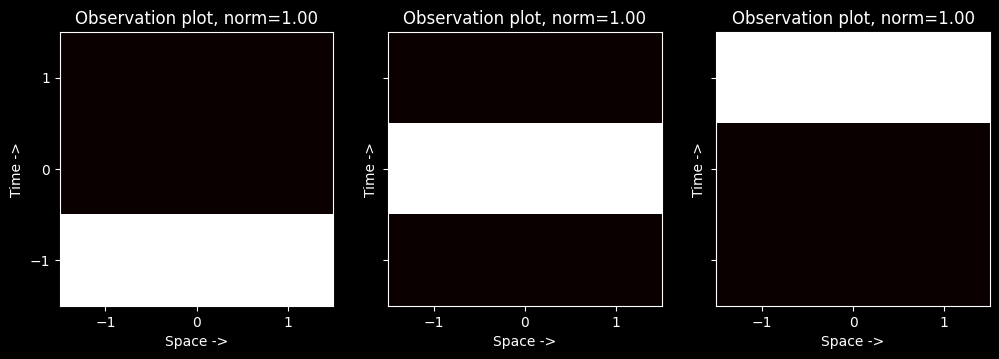

In [19]:
_, ax = plt.subplots(1,3, sharey=True, figsize=(12,4))
display_obs(v(-1), ax=ax[0])
display_obs(v(0), ax=ax[1])
display_obs(v(1), ax=ax[2])

We give the matrices for the element of G when they act on the v(-1)..v(1) basis of $\mathcal{V}$.

In [20]:
def mat_V(x,t,a):
    """ Matrix action on v(-1)..v(1)
    For g=D^xH^tB^a
    """
    mat_D = np.matrix(w*np.identity(3))
    mat_H = np.matrix([
        [0,1,0],
        [0,0,1],
        [1,0,0]
    ])
    mat_B = np.matrix(np.diag([m,1,w]))
    return (mat_D**x) * (mat_H**t) * (mat_B**a)

In [21]:
print("Testing that the matrices are correct for V action...")
rand_obs_V = np.random.normal(size=3)
def V_to_obs(vect_V):
    return np.einsum(
        "ijk,i->jk",
        np.stack([v(-1), v(0), v(1)]),
        np.array(vect_V).reshape(-1)
    )

np.testing.assert_allclose(
    V_to_obs(np.array(mat_V(1,0,0) @ rand_obs_V)),
    act_D(V_to_obs(rand_obs_V))
)
np.testing.assert_allclose(
    V_to_obs(np.array(mat_V(0,1,0) @ rand_obs_V)),
    act_H(V_to_obs(rand_obs_V))
)
np.testing.assert_allclose(
    V_to_obs(np.array(mat_V(0,0,1) @ rand_obs_V)),
    act_B(V_to_obs(rand_obs_V))
)
print("Ok.")

Testing that the matrices are correct for V action...
Ok.


We can also present V by a basis of eigenvectors H:

In [22]:
h_inv = v(-1) + v(0) + v(1)
h_w = w*v(-1) + 1*v(0) + m*v(1)
h_m = m*v(-1) + 1*v(0) + w*v(1)
for v_i, lambda_i in zip([h_inv, h_w, h_m], [1, m, w]):
    np.testing.assert_allclose(act_H(v_i), lambda_i*v_i)
    
np.testing.assert_allclose(act_B(h_inv), h_m)
np.testing.assert_allclose(act_B(h_m), h_w)
np.testing.assert_allclose(act_B(h_w), h_inv)

Here we give a similar decomposition for V'.
We see that the basis is just given by conjugation of basis for V.
* Time translation still shifts the basis vector in the same direction
* Space translations multiplies by $\bar \omega$ (which we write m)
* Boosts twists again but in the opposite direction as for V

In [23]:
def v_prime(t):
    return np.conjugate(v(t))

In [24]:
print("Test actions of D,H,B on basis of V'...")
for t in [-1, 0,1]:
    np.testing.assert_allclose(
        act_D(v_prime(t)), m*v_prime(t),
        err_msg="D should just multiply everything by m"
    )
for e_i, lam_i in zip([v_prime(-1), v_prime(0), v_prime(1)], [w,1,m]):
    np.testing.assert_allclose(act_B(e_i), lam_i*e_i,
        err_msg="v(i) should be eigenvector of B"
    )
for t in [-1, 0,1]:
    np.testing.assert_allclose(
        act_H(v_prime(t)), v_prime(t-1),
        err_msg="H should circle the eigen vectors"
    )
print("Ok.")

Test actions of D,H,B on basis of V'...
Ok.


Matrices for the action of G on v'(-1)..v(1).

In [25]:
def mat_V_prime(x,t,a):
    """ Matrix action on v(-1)..v(1)
    For g=D^xH^tB^a
    """
    mat_D = np.matrix(m*np.identity(3))
    mat_H = np.matrix([
        [0,1,0],
        [0,0,1],
        [1,0,0]
    ])
    mat_B = np.matrix(np.diag([w,1,m]))
    return (mat_D**x) * (mat_H**t) * (mat_B**a)

In [26]:
print("Checks that the basis of the irreps is orthonormal...")
basis = [u(-1), u(0), u(1), 
         v(-1), v(0), v(1), 
         v_prime(-1), v_prime(0), v_prime(1)]
BF_mat = np.zeros((len(basis),len(basis)), dtype=complex)
for x_i, x in enumerate(basis):
    for y_i, y in enumerate(basis):
        BF_mat[x_i, y_i] = BF(x,y)
np.testing.assert_allclose(BF_mat, np.identity(9), atol=1e-7)
print("Ok.")

Checks that the basis of the irreps is orthonormal...
Ok.


Now that we have a basis for the 5 irreps of $\mathcal{F}$, we can make a function that decompose an arbitrary irrep in the xt basis into the irrep basis.

In [27]:
# let's make a procedure that decompose an observation into the irreps
def decompose(obs):
    """ Decompose an observation into irreps.
    Args:
      obs (mat): 3x3 complex matrix
    Returns:
    """
    basis = [u(-1), u(0), u(1), 
         v(-1), v(0), v(1), 
         v_prime(-1), v_prime(0), v_prime(1)]
    decomp = np.zeros(len(basis), dtype=complex)
    for i, e_i in enumerate(basis):
        decomp[i] = BF(obs, e_i)
    return decomp

def recompose(decomp):
    """ Recompose from basis of irreps.
    Params:
        decomp (9x1 vector): in basis u(-1)..u(1),v(-1)..v(1),v'(-1)..v(1)
    """
    return np.einsum("k,kij->ij", decomp, np.stack(basis))

We create an observation of a particle at rest at 0.
We also compute its decomposition, we observe:
* A total non-null "mass" on `u(0)`
* Constant center-of-mass evolution on both V and V'

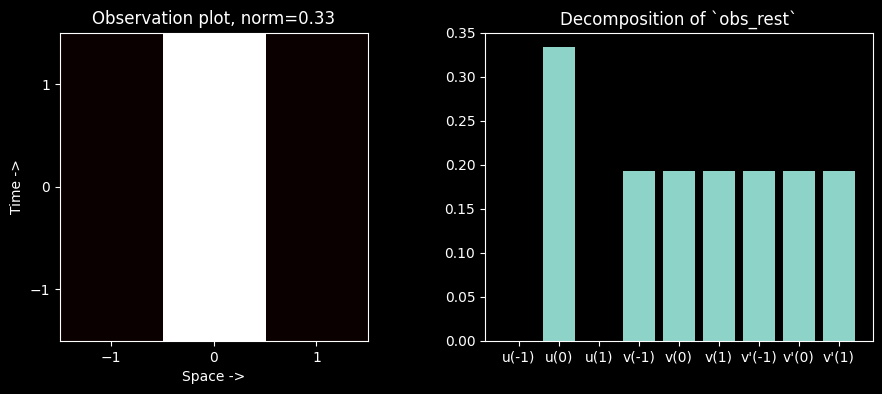

In [28]:
obs_rest = np.array([
                     [0, 1, 0],
                     [0, 1, 0],
                     [0, 1, 0]
])
_, ax = plt.subplots(1,2,figsize=(11,4))
display_obs(obs_rest, ax=ax[0])
decomp = decompose(obs_rest)
ax[1].bar(range(9), np.absolute(decomp))
ax[1].set_title("Decomposition of `obs_rest`")
ax[1].set_xticks(range(9))
ax[1].set_xticklabels(["u(-1)","u(0)","u(1)",
                     "v(-1)","v(0)","v(1)",
                     "v'(-1)","v'(0)","v'(1)"])
None

In [29]:
print("Testing that decomposing and recomposing are inverse operations...")
np.testing.assert_allclose(
    recompose(decompose(obs_rest)), obs_rest,
    atol=1e-7
)
print("Ok.")

Testing that decomposing and recomposing are inverse operations...
Ok.


### 2.4 Interpretation of the Decomposition

Here we give an interpretation of the basis vectors, for $o$ a real-valued observation.
For example, we can suppose that $o(x,t)$ represents the mass measured at position x and time t.
* The component on u(0) is given by ${1 \over 9} \sum_{i,j} o(i,j)$.  
    It can be interpreted as the total mass of the observation.
    It is an invariant of the observation.
* The components on u(1) and u(-1) are conjugates => we have 
    $\overline{\langle o | u(-1)\rangle} = \langle o | u(1) \rangle$
    * An explicit formula for the component on u(1):
        $\langle o | u(1) \rangle= {1 \over 9} \sum_{i,j \in [-1,0,1]} o(i,j)\omega^i$
* The condition "component on u(1) is null" is equivalent to the condition "mass is conserved in time".  
    Since we will often consider observations of mass evolving according to the law of classical mechanics, in which mass is conserved, we will often use this result.
* The coefficent on $v(i)$ is the conjugate of the one on $v'(i)$
* The coefficient of the irrep $\mathcal{V}$ can be interpreted as the trajectory of the center of mass.  
    The coefficient at time i is given by: $\langle o | v(i) \rangle= {\sqrt{3} \over 9} \left [ o(i,-1) \omega^{-1} + o(i,0) + o(i,1) \omega \right ]$  
    We can interpret this formula by putting particles of mass o(-1), 0(0), 0(1), respectively at positions $\omega^{-1}$, 1, $\omega$ on the unit circle, and averaging to get the center of mass.
    Since the action of D "wraps around" the space axis back to itself, it makes sense to consider the space axis as a circle rather than as a line.

## 3. Harmonic Analysis

The formula for the Fourier transform that I have, uses functions defined on the group G itself.
Our observations are defined on the space time torus... but we can extend them to a function on the whole of G.
If f is an observation, we define its extension $f'$ by:
$f': g \mapsto (g \cdot f)(0,0)$

We can compute f back from f' using the formula: $f(x,t) = f'(D^{x}H^{t})$

Letting $\rho$ denote an irrep and g an element of G.
The formula for Fourier inversion are given by:
* $\hat{f'}(\rho) = \sum_g f'(g) \rho(g)$
* $f'(g)={1 \over G} \sum_{\rho} \dim V_{\rho} \mathrm{tr}(\rho(g^{-1}) \cdot \hat{f'}(\rho))$

So we get the following equations for f:
* $\hat{f}(\rho) = \sum_g (g \cdot f)(0,0) \rho(g)$
* $f(x,t) = {1 \over G} \sum_{\rho} \dim V_{\rho} \mathrm{tr}(\rho(D^{-x}H^{-t}) \cdot \hat f(\rho))$

### 3.1 Definition

In [30]:
def fourier(obs):
    """ Fourier decomposition. """
    span = [-1, 0, 1]
    # component on u(s,a)
    comp_u = np.zeros((3,3), dtype=complex)
    for s,a in itertools.product(span, span):
        for x,t,v in itertools.product(span,span,span):
            comp_u[xt(s,a)] += act(x,t,v)(obs)[xt(0,0)]*U_char(s, a)(x,t,v)
            
    # component on V
    comp_V = np.zeros((3,3), dtype=complex)
    for x,t,a in itertools.product(span,span,span):
        comp_V += act(x,t,a)(obs)[xt(0,0)]*mat_V(x,t,a)
    # component on V'
    comp_V_prime = np.zeros((3,3), dtype=complex)
    for x,t,a in itertools.product(span,span,span):
        comp_V_prime += act(x,t,a)(obs)[xt(0,0)]*mat_V_prime(x,t,a)
    return comp_u, np.matrix(comp_V), np.matrix(comp_V_prime)

def fourier_inv(
    u_comp=np.zeros(shape=(3,3)), 
    v_comp=np.zeros(shape=(3,3)), 
    v_prime_comp=np.zeros(shape=(3,3))
):
    # make sure the inputs are matrices
    v_comp, v_prime_comp = np.matrix(v_comp), np.matrix(v_prime_comp)
    obs = np.zeros((3,3), dtype=complex)
    span = [-1, 0, 1]
    for x,t in itertools.product(span, span):
        # u comp
        for s,a in itertools.product(span,span):
            obs[xt(x,t)] += U_char(s,a)(-x,-t,0)*u_comp[xt(s,a)]
        # V comp
        obs[xt(x,t)] += 3*np.trace(mat_V(-x,-t,0)@v_comp)
        # V' comp
        obs[xt(x,t)] += 3*np.trace(mat_V_prime(-x,-t,0)@v_prime_comp)
    obs = obs/27
    return obs

In order to help debugging, we notice through a simple computation that the Fourier components on V and V' are conjugates to each other when the input is real.

In [31]:
print("Testing that V and V' comp. are conjugates for real obs...")
u_comp, v_comp, vp_comp = fourier((obs_rest))
np.testing.assert_allclose(
    v_comp,
    np.conjugate(vp_comp),
    atol=1e-7,
    err_msg="We expect Fourier component on V and V' to be conjugates for real obs"
)
print("Ok.")

Testing that V and V' comp. are conjugates for real obs...
Ok.


Proof of the Fourier inversion formula, see this 
[math.stackexchange question](https://math.stackexchange.com/questions/3258833/fourier-inversion-theorem-and-plancherels-identity-in-the-context-of-representa)
for more details.

We have:  
$${1 \over G} \sum_{\rho} \dim V_{\rho} \mathrm{tr}(\rho(g^{-1}) \cdot \hat{f'}(\rho)) \\
= {1 \over G} \sum_{\rho} \sum_h \mathrm{tr}(\rho(e)) \mathrm{tr}(\rho(g^{-1}h)) f(h) \\
= \sum_h \left [ {1 \over G} \sum_{\rho} \overline{\mathrm{tr}(\rho(e))} \mathrm{tr}(\rho(g^{-1}h)) \right ] f(h) \\
= f(g)
$$

Where the first equality is given by the Fourier transform formula and the last one by the orthogonality of characters.

In [32]:
print("Testing that Fourier and Fourier inv are inverses...")
random_obs = np.random.normal(size=(3,3)) + np.random.normal(size=(3,3))*1j
np.testing.assert_allclose(
    fourier_inv(*fourier(random_obs)),
    random_obs)
print("Ok.")

Testing that Fourier and Fourier inv are inverses...
Ok.


We can explicit the construction of f' from f, using the action of the group on events (x,t), as defined in `Galilean1p1.act_event`.
We have:  
$$f'(g) = (g \cdot f)(0,0) = f(g^{-1} \cdot (0,0))$$
Writing $g = D^xH^tB^v$ we get:
$$f'(D^xH^tB^v) = f(x+tv,t)$$

### 3.2 Interpretation of the Fourier Coefficients


Let's start with computing the Fourier transform for a random obs.

In [33]:
this_obs = np.random.normal(size=(3,3)) + np.random.normal(size=(3,3))*1j
u_comp, v_comp, vp_comp = fourier(this_obs)
with np.printoptions(precision=2,suppress=True):
    print("Original observation")
    print(np.abs(this_obs))
    print("U comp")
    print(np.abs(u_comp))
    print("V comp")
    print(np.real(v_comp))
    print(np.imag(v_comp))
    print("Rank of V comp: {}".format(np.linalg.matrix_rank(v_comp)))


Original observation
[[1.65 1.03 0.6 ]
 [1.5  1.76 1.18]
 [0.89 1.62 0.82]]
U comp
[[ 0.    0.    0.  ]
 [ 2.79  5.21 12.16]
 [ 0.    0.    0.  ]]
V comp
[[ 0.   -0.   -0.  ]
 [ 4.4   1.41  5.05]
 [-0.    0.    0.  ]]
[[ 0.    0.    0.  ]
 [-7.44 10.28  2.05]
 [ 0.   -0.    0.  ]]
Rank of V comp: 1


__Interpretation of Fourier Coefficients__: The Fourier coefficients corresponds to the observation's decomposition in an orthogonal basis made from the irreducible representations basis vectors.
Let O be an observation.
The components of $\hat O$ are given by:
* $\hat O (\mathcal{U}(s,0)) = 27 \langle O, u(-s,0) \rangle$
* $\hat O (\mathcal{V}) = 9 \sqrt{3} \begin{pmatrix}
    0 & 0 & 0 \\
    \langle O, v'(-1) \rangle & \langle O, v'(0) \rangle & \langle O, v'(1) \rangle \\
    0 & 0 & 0
    \end{pmatrix}$
* $\hat O (\mathcal{V'}) = 9 \sqrt{3} \begin{pmatrix}
    0 & 0 & 0 \\
    \langle O, v(-1) \rangle & \langle O, v(0) \rangle & \langle O, v(1) \rangle \\
    0 & 0 & 0
    \end{pmatrix}$
    
This means that the Fourier decomposition does not bring more information than the irreducible decomposition.
Indeed, we can read the components of the irreducible decomposition of $O$ in its Fourier transform.
Do note that the Fourier component of $\mathcal{U}(1,0)$ is proportional to the irreducible component on $\mathcal{U}(-1,0)$ (note the minus sign).
In the same vein, the Fourier component on $\mathcal{V}$ has to be read from the irreducible component on $\mathcal{V'}$.

In the end, we can give the same physical interpretation to the Fourier components as we did for the irreducible components, since they are equal up to swapping and a multiplicative factor.

In [34]:
print("Test of the formula above...")
this_obs = np.random.normal(size=(3,3)) + np.random.normal(size=(3,3))*1j
u_comp, v_comp, vp_comp = fourier(this_obs)

np.testing.assert_allclose(
    v_comp,
    9*np.sqrt(3)*np.stack([
        [0,0,0],
        np.array([BF(this_obs, v_prime(i)) for i in [-1, 0, 1]]),
        [0,0,0]
    ]),
    atol=1e-7
)

np.testing.assert_allclose(
    vp_comp,
    9*np.sqrt(3)*np.stack([
        [0,0,0],
        np.array([BF(this_obs, v(i)) for i in [-1, 0, 1]]),
        [0,0,0]
    ]),
    atol=1e-7
)

np.testing.assert_allclose(
    u_comp[1,:], 
    27*np.array([BF(this_obs, u(i)) for i in [1, 0, -1]])
)
print("Ok.")

Test of the formula above...
Ok.


### 3.3 Interpretation of the Product

The operation of convolution is closely linked to Fourier analysis.
For finite groups, the convolution is given by:
$$\phi \star \psi (g) = \sum_{h\in G} \phi(h)\psi(h^{-1}g)$$

Let $O,P$ be two obervations, we can define the convolution $O' \star P'$ and pull it back to obtain an observation $O \star P$:
$$O \star P (x,t) = \sum_{h\in G} (h \cdot O)(0,0) \times (h^{-1}D^xH^t \cdot P)(0,0)$$

Which we can rewrite as:
$$O \star P (x,t) = \sum_{y,s,a\in [-1,0,1]^3} O(y+sa,s) P(x-y,t-s)$$

This formula is implemented in the function `conv` below.

In [35]:
def conv(obs1, obs2, *kargs):
    """ Convolution of observations.
    Args:
        obs1 (np 3x3): observation
        obs2 (np 3x3): observation
        kargs: more observations
    Returns:
        A 3x3 observation.
    """
    if len(kargs) > 0:
        return conv(obs1, conv(obs2, *kargs))
    
    res = np.zeros(shape=(3,3), dtype=complex)
    for x,t in itertools.product(span,span):
        for y,s,a in itertools.product(span, span, span):
            res[xt(x,t)] += obs1[xt(y+s*a,s)]*obs2[xt(x-y,t-s)]
    
    return res

For fun, we try convolving the observation of a particle at rest (mass of 1 at x=0 for all t, 0 everywhere else).
We observe that the convolution spreads the observation until the observation looks uniform.

In [36]:
print("Testing convergence to uniform observation...")
obs_rest = np.array([
    [0,1,0],
    [0,1,0],
    [0,1,0]
])
obs_uniform = np.ones_like(obs_rest)
conv(obs_rest, obs_rest)
res = conv(*[obs_rest]*50)
np.testing.assert_allclose(res/np.sqrt(BF(res)), obs_uniform)
print("Ok.")

Testing convergence to uniform observation...
Ok.


The Fourier transform exhibits the ring-isomorphism between the group ring $\mathbb{C}G$ (with multiplication given by convolution) and a direct product of matrix rings.

In our case, the Fourier ring is a direct product of:
* The $\mathcal{U}$ Fourier component, isomorphic to $\mathbb{C}^3$
* The $\mathcal{V}$ Fourier component, this matrix ring is made of all matrices of this type:
$$ \begin{pmatrix}
0 & 0 & 0 \\
a & b & c \\
0 & 0 & 0
\end{pmatrix}
$$
* The $\mathcal{V'}$ Fourier component, which is isomorphic to the previous one.

The Fourier isomorphism is given by the convolution product formula:
$$\widehat{O \star P} = \hat O \times \hat P$$

In [37]:
print("Testing the Fourier product formula...")
rand_obs_1 = np.random.normal(size=(3,3)) + np.random.normal(size=(3,3))*1j
rand_obs_2 = np.random.normal(size=(3,3)) + np.random.normal(size=(3,3))*1j
obs_3 = conv(rand_obs_1, rand_obs_2)
o3_u, o3_v, o3_vp = fourier(obs_3)

o1_u, o1_v, o1_vp = fourier(rand_obs_1)
o2_u, o2_v, o2_vp = fourier(rand_obs_2)
np.testing.assert_allclose(
    o3_u,
    o1_u*o2_u,
    atol=1e-7
)
np.testing.assert_allclose(
    o3_v,
    o1_v*o2_v,
    atol=1e-7
)
np.testing.assert_allclose(
    o3_vp,
    o1_vp*o2_vp,
    atol=1e-7
)
print("Ok.")

Testing the Fourier product formula...
Ok.


The product formula helps give further intuition behind the convolution operator, giving it a filter meaning.


To help understand this, let's focus on an example, convolution by $v(0)$.
Since this observation only has non-zero Fourier coefficients on $\mathcal{V'}$, the result of the convolution $v(0) \star O$ for any observation O, will also have null zero-coefficients everywhere but on $\mathcal{V'}$.
This corresponds to an observation that only have an irred. component on $\mathcal{V}$.
In that sense, the operation $v(0) \star \_$ projects an observation down to the $v(0)$ component.

We can do the same for any other irrep. basis vector!

## 4. Real Representations

We have a decompositions into irreps over $\mathbb{C}$:
$$\mathcal{F} = \mathcal{U}_{-1,0} \oplus \mathcal{U}_{0,0} \oplus \mathcal{U}_{1,0} \oplus \mathcal{V} \oplus \mathcal{V'}$$

We have $\mathcal{F}_\mathbb{R}$ the space of real valued observations and $\mathcal{F}_\mathbb{R} \otimes \mathbb{C} = \mathcal{F}$
$\mathcal{F}_\mathbb{R} \otimes \mathbb{C} = \mathcal{U}_{-1,0} \oplus \mathcal{U}_{0,0} \oplus \mathcal{U}_{1,0} \oplus \mathcal{V} \oplus \mathcal{V'}$

$\mathcal{F}_\mathbb{R} \otimes \mathbb{C} = \mathcal{U}_{0,0} \oplus (\mathcal{U}_{-1,0} \oplus \mathcal{U}_{1,0}) \oplus (\mathcal{V} \oplus \mathcal{V'})$

We use the following definition from "A First Course in Representation Theory".

__Definition__ Let V be a complex representation.
We call V _real_, if there is $V_0$ a representation on a real vector space,
such that $V = V_0 \oplus \mathbb{C}$.

__Properties__
* If $V_0$ is irreducible over $\mathbb{R}$, then $V$ is either irreducible over $\mathbb{C}$ or the direct sum of two irreducible and conjugate representations.

* $\Re(\mathcal{U_{0,0}}) = \mathbb{R} \cdot \begin{pmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{pmatrix}$
* $\Re(\mathcal{U}_{-1,0} \oplus \mathcal{U}_{1,0}) = 
\mathbb{R} \cdot \begin{pmatrix} -1/2 & -1/2 & -1/2 \\ 1 & 1 & 1 \\ -1/2 & -1/2 & -1/2\end{pmatrix} + 
\mathbb{R} \cdot \begin{pmatrix} \sqrt{3}\over2 & \sqrt{3}\over2 & \sqrt{3}\over2 \\ 1 & 1 & 1 \\ \sqrt{3}\over2 & \sqrt{3}\over2 & \sqrt{3}\over2 \end{pmatrix}
$
* $\Re(\mathcal{V} \oplus \mathcal{V'}) = 
\mathbb{R} \cdot \begin{pmatrix} 0 & 0 & 0 \\ 0 & 0 & 0 \\ -1/2 & 1 & -1/2\end{pmatrix} +
\mathbb{R} \cdot \begin{pmatrix} 0 & 0 & 0 \\ 0 & 0 & 0 \\ -\sqrt{3}\over2 & 0 & \sqrt{3}\over2\end{pmatrix} + \\
\mathbb{R} \cdot \begin{pmatrix} 0 & 0 & 0 \\ -1/2 & 1 & -1/2 \\ 0 & 0 & 0 \end{pmatrix} +
\mathbb{R} \cdot \begin{pmatrix} 0 & 0 & 0 \\ -\sqrt{3}\over2 & 0 & \sqrt{3}\over2 \\ 0 & 0 & 0\end{pmatrix} + \\
\mathbb{R} \cdot \begin{pmatrix} -1/2 & 1 & -1/2 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{pmatrix} +
\mathbb{R} \cdot \begin{pmatrix} -\sqrt{3}\over2 & 0 & \sqrt{3}\over2 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{pmatrix}$

For the irreducible (real) representations of the type $V_0 \otimes \mathbb{C} = W \oplus \overline W$, if we have a basis $e_1, ..., e_n$ for W, then we can denote $e_1, .., e_n, \overline{e_1}, ..., \overline{e_n}$ a basis for the direct sum.

Since the matrices of the actions for any $g\in G$ for $W$ and $\overline W$ are conjugate, we can check by direct computation that in the basis $e_1+\overline e_1, ..., e_n+\overline e_n, i\overline e_1 - ie_1, ..., i\overline e_n - ie_n$, this matrix has only real entries.

In turn this gives the real representation we were looking for!
Below, we give a function to compute the matrices for any g.

In [95]:
def mat_real_center_mass(x,t,a):
    # this is the complex action matrix on V+V'
    A = np.block([
        [mat_V(x,t,a), np.zeros((3,3))],
         [np.zeros((3,3)), mat_V_prime(x,t,a)]
    ])
    # this is the change of basis matrix
    M = np.array([
        [1,0,0,-1j,0,0],
        [0,1,0,0,-1j,0],
        [0,0,1,0,0,-1j],
        [1,0,0,1j,0,0],
        [0,1,0,0,1j,0],
        [0,0,1,0,0,1j]
    ])
    M = np.transpose(M)
    return np.real(M@A@np.linalg.inv(M))

def mat_real_mass_imbalance(x,t,a):
    # this is the complex action matrix on V+V'
    A = np.array([
        [U_char(-1, 0)(x,t,a), 0],
         [0, U_char(1,0)(x,t,a)]
    ])
    # this is the change of basis matrix
    M = np.array([
        [1,-1j],
        [1,1j],
    ])
    M = np.transpose(M)
    return np.real(M@A@np.linalg.inv(M))

In [96]:
# Here we test that the matrices verify the commutation relations
Dr, Hr, Br = (mat_real_center_mass(1,0,0), 
              mat_real_center_mass(0,1,0), 
              mat_real_center_mass(0,0,1))
np.testing.assert_allclose(Dr@Hr, Hr@Dr)
np.testing.assert_allclose(Dr@Br, Br@Dr)
np.testing.assert_allclose(Dr@Br@Hr, Hr@Br)

# Here we test that the matrices verify the commutation relations
Dr, Hr, Br = (mat_real_mass_imbalance(1,0,0), 
              mat_real_mass_imbalance(0,1,0), 
              mat_real_mass_imbalance(0,0,1))
np.testing.assert_allclose(Dr@Hr, Hr@Dr)
np.testing.assert_allclose(Dr@Br, Br@Dr)
np.testing.assert_allclose(Dr@Br@Hr, Hr@Br)

## Conclusion

It was a fun exercise in the representation theory of finite groups!

In [102]:
# this renders the notebook
!jupyter nbconvert 'Finite_gal_1+1.ipynb' --to markdown --no-input --output-dir=markdown 

[NbConvertApp] WARNING | Unrecognized alias: 'out', it will have no effect.
[NbConvertApp] Converting notebook Finite_gal_1+1.ipynb to markdown
[NbConvertApp] Support files will be in Finite_gal_1+1_files/
[NbConvertApp] Making directory markdown/Finite_gal_1+1_files
[NbConvertApp] Making directory markdown/Finite_gal_1+1_files
[NbConvertApp] Making directory markdown/Finite_gal_1+1_files
[NbConvertApp] Making directory markdown/Finite_gal_1+1_files
[NbConvertApp] Writing 21914 bytes to markdown/Finite_gal_1+1.md
